# Computer Class 5 - model averaging and the EM-algorithm
The examples and exercises in this computer class introduce the student to the application of various model averaging strategies and the EM-algorithm applied to Gaussian mixture models.

*Authors: Cees Diks and Bram Wouters, Faculty Economics and Business, University of Amsterdam (UvA)* <br>
*Copyright (C): UvA (2023)* <br>

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import stats

import matplotlib as mpl

# Part 1: Model averaging 
In this section, you will apply different model averaging strategies to the simple regression problem of Computer Class 3. In the cell below a data set of 20 points is generated and visualized, and the functions for training a polynomial model are given.

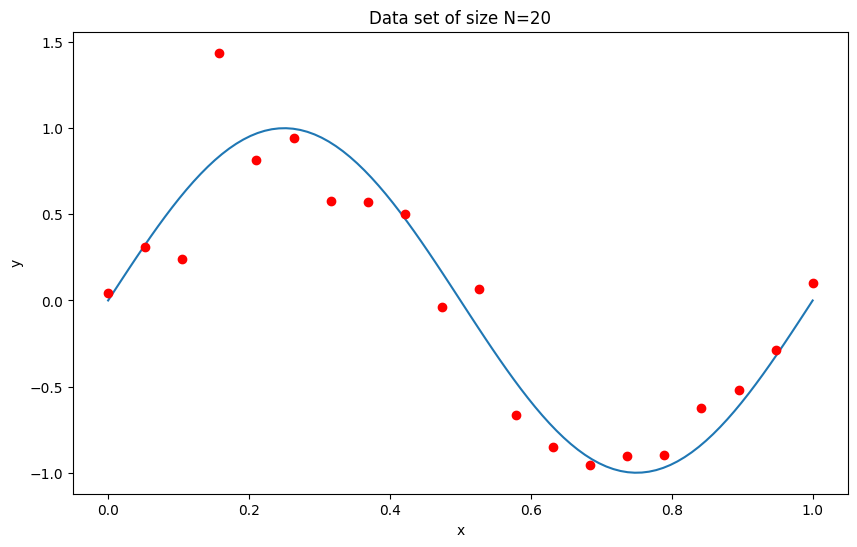

In [55]:
N = 20
sigma = 0.2

def f(x): return np.sin(2*np.pi*x) # The sinusoidal function underlying the data-generating process

X = np.linspace(0, 1, N).reshape(N,1) # Features are stored in a 2-dimensional ndarray
eps = np.random.normal(0, sigma, N)
y = f(X.reshape(N)) + eps # The target variable is stored in a 1-dimensional ndarray

# Plotting the datapoints and the underlying model:
fig1 = plt.figure(1, figsize=(10,6))
ax = fig1.add_subplot(1,1,1)

x_range = np.linspace(0,1,100)
ax.plot(x_range, f(x_range)) # Plotting the sinusoid
ax.plot(X, y, 'o', color='red') # Plotting the data points

ax.set_title('Data set of size N={}'.format(N))

ax.set_xlabel('x')
ax.set_ylabel('y')

def polynomial_features(X, M):
    return np.concatenate(tuple([X**n for n in range(M+1)]), axis=1)

def get_parameters_lin_mod(X, y):
    return np.linalg.pinv(X) @ y

def train_lin_mod(X, y):
    
    parameters = get_parameters_lin_mod(X, y)
    
    def fhat(X_new): return X_new @ parameters
    
    return fhat   

**Example:** in the cell below we are creating a 2-dimensional NumPy array `X_model_predictions`. This matrix has N rows and $M_{max} - M_{min} + 1$ columns. Each column represents a model with a different value of M, where M ranges from `Mmin` (leftmost column) until `Mmax` (rightmost column). Each row represents the predictions of the different models on a point in `X`, where the specific point was (of course) excluded when the models were trained. The matrix `X_model_predictions`, combined with the target variabel `y`, is a natural starting point for model averaging in a regression context and can be used the in following exercises. We are also visualizing the content of `X_model_predictions`.

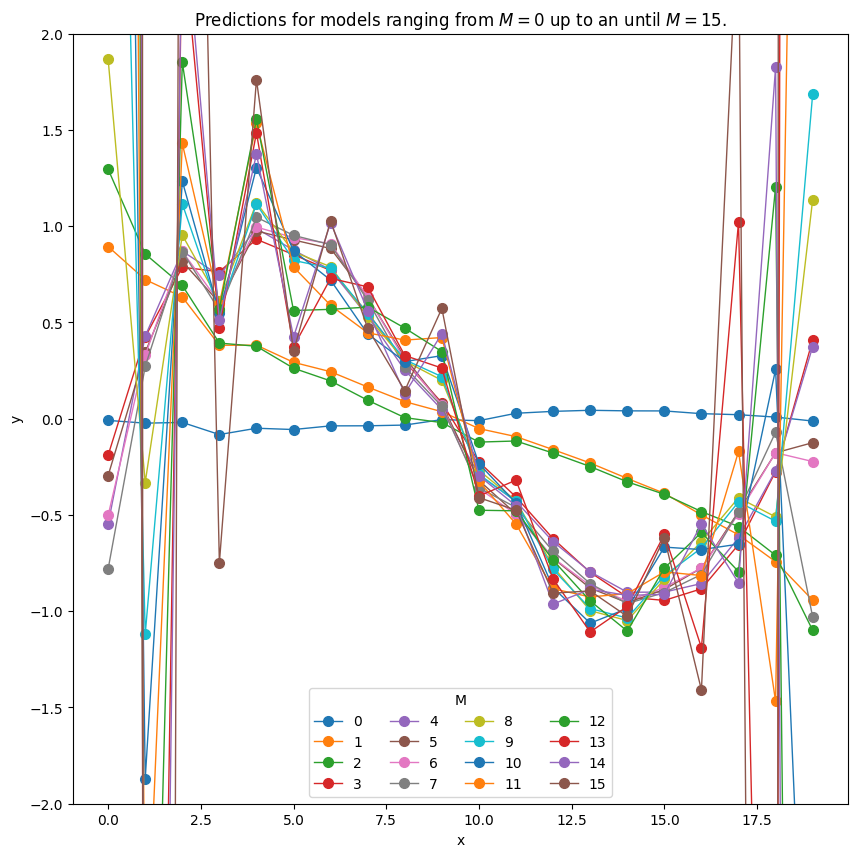

In [56]:
Mmin = 0
Mmax = 15

predictions = np.array([])
for M in range(Mmin, Mmax+1):
    
    X_derived = polynomial_features(X,M)
    
    for i in range(N):
        
        model_temp = train_lin_mod(np.delete(X_derived, i, axis=0), np.delete(y, i))
        
        predictions = np.append(predictions, model_temp(X_derived[i]))
               
X_model_predictions = predictions.reshape(Mmax - Mmin + 1, N).T

# Plotting X_model_predictions
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

ax1.set_title("Predictions for models ranging from $M= {}$ up to an until $M = {}$.".format(Mmin, Mmax))

ax1.plot(X_model_predictions, 'o-', linewidth=1, markersize=7)

ax1.set_xlabel("x")

ax1.set_ylim(bottom=-2, top=2)
ax1.set_ylabel("y")

ax1.legend(range(Mmin, Mmax+1), ncol=4, title="M");

**Exercise 1:** apply equal-weights averaging to compute the weights of the combined model. Also compute the RMSE of this combined forecast. (Note that you don't need to worry about a test/train-split in this case.)

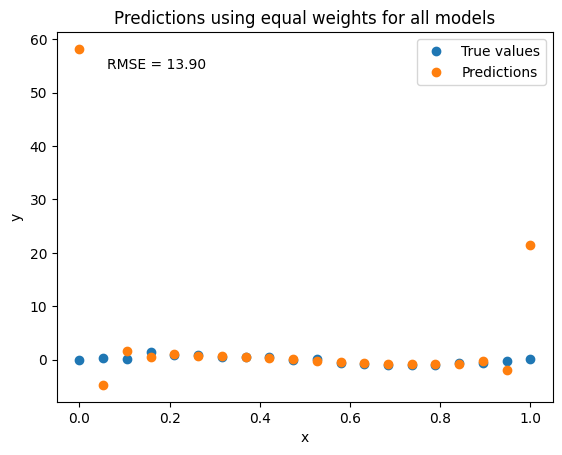

In [57]:
def RMSE(y, y_hat):
    return np.sqrt(np.mean(np.pow(y - y_hat, 2)))

def plot_y_y_hat(x, y: np.ndarray, y_hat: np.ndarray, rmse: float, title: str):
    # plt.figure(figsize=(10,10))
    plt.plot(x, y, 'o', label='True values')
    plt.plot(x, y_hat, 'o', label='Predictions')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.text(0.1, 0.9, 'RMSE = {:.2f}'.format(rmse), transform=plt.gca().transAxes) 

equal_weights_y_hat = np.mean(X_model_predictions, axis=1)
rmse = RMSE(y, equal_weights_y_hat)
plot_y_y_hat(X, y, equal_weights_y_hat, rmse, 'Predictions using equal weights for all models')

**Exercise 2:** apply Bates-Granger averaging to compute the weights of the combined model. Also compute the RMSE of this combined forecast. (Note that, strictly speaking, you need to perform cross-validation to estimate the RMSE.)

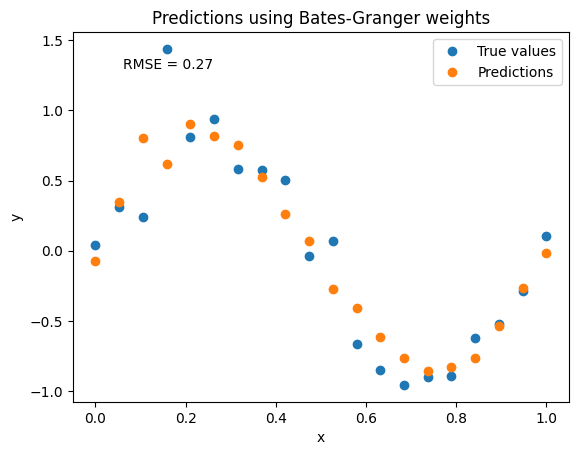

In [58]:
forcast_errors = np.zeros_like(X_model_predictions)
for i in range(Mmin, Mmax+1):
    forcast_errors[:,i] = y - X_model_predictions[:,i]
bates_granger = 1.0 / np.var(forcast_errors, axis=0)
bates_granger_weights = bates_granger / np.sum(bates_granger)
bates_granger_y_hat = np.sum(X_model_predictions * bates_granger_weights, axis=1)

rmse = RMSE(y, bates_granger_y_hat)
plot_y_y_hat(X, y, bates_granger_y_hat, rmse, 'Predictions using Bates-Granger weights')

**Exercise 3:** apply AICA to compute the weights of the combined model. Also compute the RMSE of this combined forecast. (Note that, strictly speaking, you need to perform cross-validation to estimate the RMSE. For practical purposes, you don't need to do that here.)

**Answer:** assuming that the noise is Gaussian distributed, the log-likelihood of model $m$ is given by
$$ \log(L_m) = - \frac{1}{2} \sum_{i=1}^N \frac{({\bf y}_i - {\bf X}_{m,i})^2}{\hat{\sigma \,}_m^2} - \frac{1}{2} \log(2\pi \hat{\sigma \,}_m^2). $$

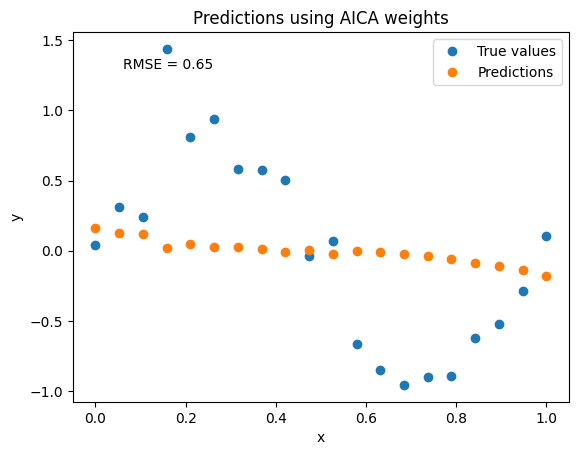

In [59]:
def log_likelihood(model: int, X_model_predictions: np.ndarray, y: np.ndarray) -> float:
    X_m = X_model_predictions[:,model]
    forcast_error = y - X_m
    sigma_squared_m = np.var(forcast_error)
    return -1.0/2 * np.sum(np.pow(forcast_error, 2) / sigma_squared_m) - 1.0/2 * np.log(2 * np.pi * sigma_squared_m)

def get_aica_weights(X_model_predictions: np.ndarray, y: np.ndarray) -> np.ndarray:
    M = X_model_predictions.shape[1]
    log_likelihoods = np.zeros(M)
    for m in range(M):
        log_likelihoods[m] = log_likelihood(m, X_model_predictions, y)
    I = -2 * log_likelihoods + 2 * np.arange(Mmin+1, Mmax+2)
    return np.exp(-I) / np.sum(np.exp(-I))

aica_weights = get_aica_weights(X_model_predictions, y)
aica_y_hat = np.sum(X_model_predictions * aica_weights, axis=1)
rmse = RMSE(y, aica_y_hat)
plot_y_y_hat(X, y, aica_y_hat, rmse, 'Predictions using AICA weights')

**Exercise 4:** apply BICA to compute the weights of the combined model. Also compute the RMSE of this combined forecast. (Note that, strictly speaking, you need to perform cross-validation to estimate the RMSE. For practical purposes, you don't need to do that here.)

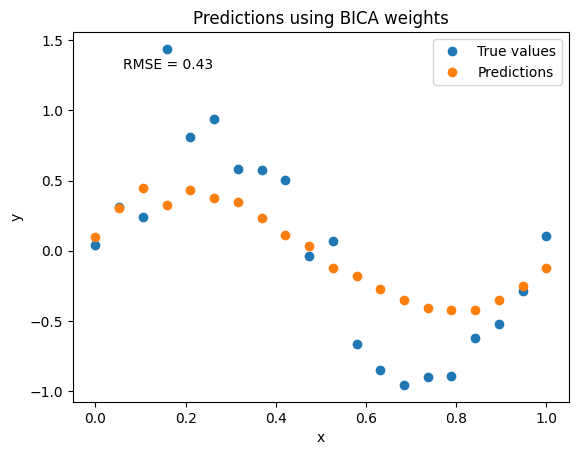

In [60]:
def get_bica_weights(X_model_predictions: np.ndarray, y: np.ndarray) -> np.ndarray:
    M = X_model_predictions.shape[1]
    log_likelihoods = np.zeros(M)
    for m in range(M):
        log_likelihoods[m] = log_likelihood(m, X_model_predictions, y)
    I = -2 * log_likelihoods + 2 * np.log(np.arange(Mmin+1, Mmax+2))
    return np.exp(-I) / np.sum(np.exp(-I))

bica_weights = get_bica_weights(X_model_predictions, y)
bica_y_hat = np.sum(X_model_predictions * bica_weights, axis=1)
rmse = RMSE(y, bica_y_hat)
plot_y_y_hat(X, y, bica_y_hat, rmse, 'Predictions using BICA weights')

**Exercise 5:** apply Granger-Ramanathan averaging to compute the weights of the combined model. Also compute the RMSE of this combined forecast. (Note that, strictly speaking, you need to perform cross-validation to estimate the RMSE. For practical purposes, you don't need to do that here.)

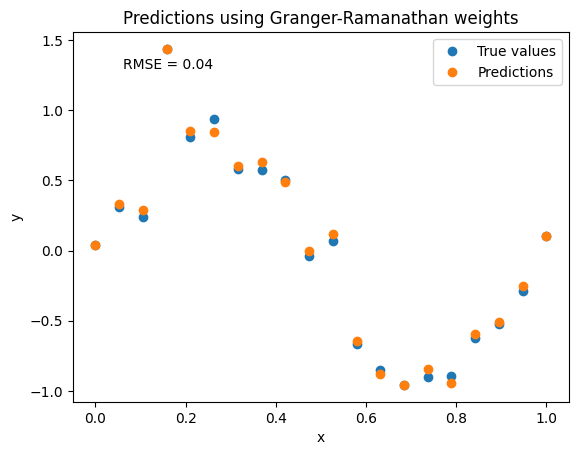

In [61]:
def get_granger_ramanathan_weights(X_model_predictions: np.ndarray, y: np.ndarray) -> np.ndarray:
    weights = np.linalg.inv(X_model_predictions.T @ X_model_predictions) @ X_model_predictions.T @ y
    return weights

granger_ramanathan_weights = get_granger_ramanathan_weights(X_model_predictions, y)
granger_ramanathan_y_hat = X_model_predictions @ granger_ramanathan_weights
rmse = RMSE(y, granger_ramanathan_y_hat)
plot_y_y_hat(X, y, granger_ramanathan_y_hat, rmse, 'Predictions using Granger-Ramanathan weights')

**Exercise 6:** which of the above model-averaging strategies works best for this specific regression problem? How reliable is your conclusion?

**Answer:** Granger-Ramanathan averaging gives the best performance, followed by BICA, AICA and Bates-Granger averaging (which are all fairly close to each other). For reliability of the conclusion, you need to know the standard error of the RMSE estimates. For this, you would need to do CV. We leave this to the reader.

# Part 2: EM-algorithm for Gaussian mixture models
In this section we apply the EM-algorithm to Gaussian mixture models.

In the cell below, some auxiliary functions for plotting are imported. Do not change this cell!

In [62]:
def plot_contour(ax, mu, Sigma, N=100, color="black"):
    
    x = np.linspace(*ax.get_xlim(), N)
    y = np.linspace(*ax.get_ylim(), N)
    X, Y = np.meshgrid(x, y)
    
    Sigma_inv = np.linalg.inv(Sigma)
    Z_prime = (X - mu[0])**2 * Sigma_inv[0,0] + 2*(X - mu[0])*(Y - mu[1]) * Sigma_inv[0,1] + (Y - mu[1])**2 * Sigma_inv[1,1]
    Z = np.exp( - Z_prime/2) / np.sqrt(2 *  np.pi * np.abs(np.linalg.det(Sigma)))
    height = np.exp( - 1/2) / np.sqrt(2 *  np.pi * np.abs(np.linalg.det(Sigma)))
    
    ax.contour(X, Y, Z, [height], colors=color)
    
    return None

def plot_all(ax, X, K=2, Y=None, means=None, Sigmas=None, Y_colors=None, N=100):
    
    color_dict = {0 : "red", 1 : "green"}
    
    if Y_colors is not None:
        ax.scatter(X[:,0], X[:,1], c=Y_colors, alpha=0.4, s=10)
    else:
        ax.scatter(X[:,0], X[:,1], c="blue", alpha=0.4, s=10)
    
    if means is not None:
        for k in range(K):
            ax.scatter(means[k][0], means[k][1], marker="x", c=color_dict[k % 2], s=100, linewidths=3)
            plot_contour(ax, means[k], Sigmas[k], color=color_dict[k % 2])
        
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

**Example:** We use the Old Faithful Geyser dataset (for more information, see [here](https://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat)). In the cell below, the data is imported and visualized.

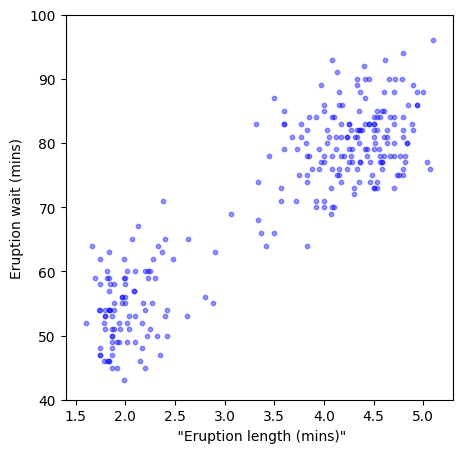

In [63]:
data = pd.read_csv("faithful.csv", index_col=0).reset_index(drop=True)
X = np.array(data)

fig, ax = plt.subplots(figsize=(5,5))

ax.set_xlim(left=1.4, right=5.3)
ax.set_ylim(bottom=40, top=100)

ax.set_xlabel(data.columns[0])
ax.set_ylabel(data.columns[1])

plot_all(ax, X, K=2, Y=None, means=None, Sigmas=None, Y_colors=None, N=100)

**Example:** we will focus on a mixture of two Gaussians ($K=2$). Before we apply the EM-algorithm, we need to choose initial values of the parameters. For the priors, we assume the data is balanced. For the covariance matrices, we use the full dataset. The means are drawn randomly from a multivariate Gaussian with mean the mean of all data and with the covariance based on the full dataset. Plotted are the 1-sigma contours of the pdf's.

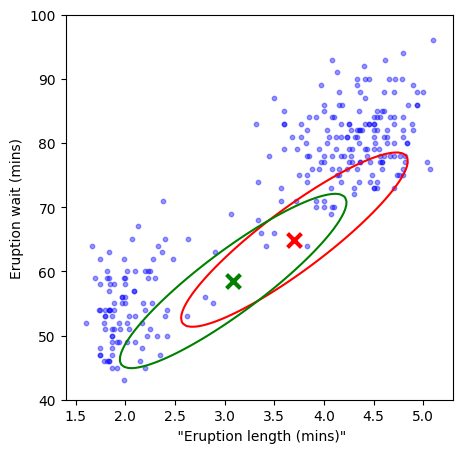

In [64]:
K = 2

Sigma = np.cov(X.T, ddof=1)
Sigmas = np.tile(Sigma, (K,1)).reshape(K, *Sigma.shape)
means = np.random.multivariate_normal(np.mean(X, axis=0), Sigma, size=(K,))
priors = np.ones(K)/2

fig, ax = plt.subplots(figsize=(5,5))

ax.set_xlim(left=1.4, right=5.3)
ax.set_ylim(bottom=40, top=100)

ax.set_xlabel(data.columns[0])
ax.set_ylabel(data.columns[1])

plot_all(ax, X, K=K, Y=None, means=means, Sigmas=Sigmas, Y_colors=None, N=100)

**Exercise 7:** write your own function `EM_algorithm` the applies the EM-algorithm for Gaussian mixture models to data `X`.

In the cell below, all the required functions are already given. Read the docstrings of the functions to understand the purpose of each of the functions. 

In the functions `compute_LL`, `E_step`, `M_step` and `EM_algorithm` some lines of code are still missing. It is your job to complete the code and make sure the EM-algorithm works accordingly.

In [65]:
def compute_LL(X, means, Sigmas, priors):
    """Computes the log-likelihood based on a Gaussian mixture model."""
    K = means.shape[0]
    N = X.shape[0]
    pXgivenZ = np.zeros((N, K))
    for k in range(K):
        pXgivenZ[:, k] = stats.multivariate_normal.pdf(X, mean=means[k], cov=Sigmas[k])
    
    pXZ = pXgivenZ * priors
    margX =  np.sum(pXZ, axis=1)
    
    return np.sum(np.log(margX))

def E_step(X, means, Sigmas, priors):
    """
    Expectation step of the EM-algorithm. This function returns a 2-dimensional ndarray of size NxK.
    The values of the matrix are the so-called responsibilities, or in other words the probabilities
    of Z given X (where Z is one-hot encoded).
    """
    K = means.shape[0]
    N = X.shape[0]
    pXgivenZ = np.zeros((N, K))
    for k in range(K):
        pXgivenZ[:, k] = stats.multivariate_normal.pdf(X, mean=means[k], cov=Sigmas[k])
    
    pXZ = pXgivenZ * priors
    margX =  np.sum(pXZ, axis=1)
    pZgivenX = pXZ / margX.reshape(-1,1)
    
    return pZgivenX

def M_step(X, pZgivenX):
    """
    Maximization step of the EM-algorithm. Computes the new parameters of the Gaussian mixture model.
    """
    
    N, M = X.shape
    K = pZgivenX.shape[1]
    
    Nk = np.sum(pZgivenX, axis=0)
    
    means = pZgivenX.T @ X / Nk.reshape(-1, 1)
    
    Sigmas = np.zeros((K, M, M))
    for k in range(K):
        X_diff = X - means[k]
        Sigmas[k] = (X_diff * pZgivenX[:, k].reshape(-1, 1)).T @ X_diff / Nk[k]
        
    priors = Nk / N
    
    return means, Sigmas, priors

def EM_algorithm(X, means, Sigmas, priors, tolerance=0.001, iter_max=100, snapshots_i=[]):
    """
    The EM-algorithm. Returns the parameters of the final Gaussian mixture model, the number of iterations,
    the final log-likelihood and (possibly) several intermediate snapshots of the parameters.
    """
    snapshots = []
    
    i = 0
    improvement = tolerance + 1.0
    LL = compute_LL(X, means, Sigmas, priors)
    if i in snapshots_i:
        snapshots.append((i, means, Sigmas, priors, LL))
    while improvement > tolerance and i < iter_max:
        
        LL_old = LL
        
        # E-step
        pZgivenX = E_step(X, means, Sigmas, priors)
        
        # M-step
        means, Sigmas, priors = M_step(X, pZgivenX)
        
        # log-likelihood
        LL = compute_LL(X, means, Sigmas, priors)
        improvement = np.abs((LL - LL_old)/LL_old)
        
        i += 1
        
        # reporting
        if i in snapshots_i:
            snapshots.append((i, means, Sigmas, priors, LL))
    
    snapshots.append((i, means, Sigmas, priors, LL))
    
    return means, Sigmas, priors, i, LL, snapshots

**Example:** the 1-sigma contours of the pdf's, after training with the EM-algorithm.

Number of iterations used: 15


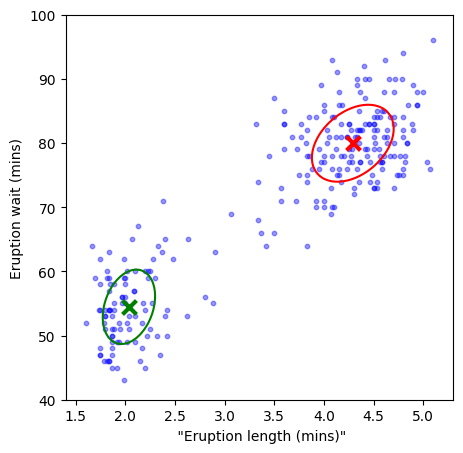

In [66]:
means, Sigmas, priors, i, _, snapshots = EM_algorithm(X,
                                                      means,
                                                      Sigmas,
                                                      priors,
                                                      tolerance=0.0001,
                                                      iter_max=100)

print("Number of iterations used: {}".format(i))

fig, ax = plt.subplots(figsize=(5,5))

ax.set_xlim(left=1.4, right=5.3)
ax.set_ylim(bottom=40, top=100)

ax.set_xlabel(data.columns[0])
ax.set_ylabel(data.columns[1])

plot_all(ax, X, K=K, Y=None, means=means, Sigmas=Sigmas, Y_colors=None, N=100)

**Example:** training of the EM-algorithm. The coloring of the scatter data is determined by the probability of Z given X.

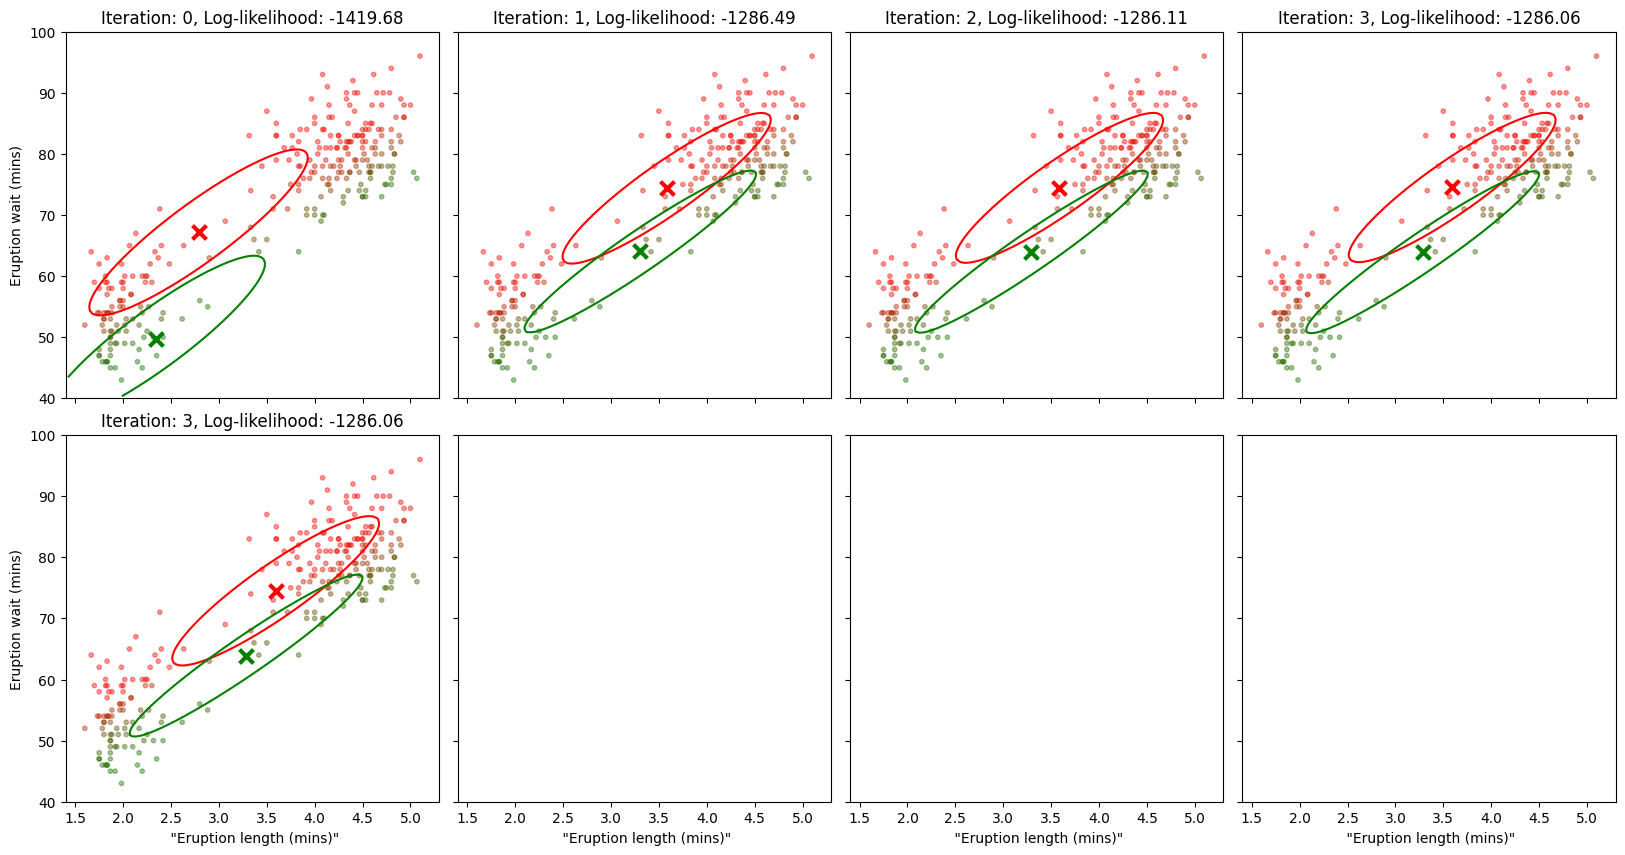

In [67]:
Sigma = np.cov(X.T, ddof=1)
Sigmas = np.tile(Sigma, (K,1)).reshape(K, *Sigma.shape)
means = np.random.multivariate_normal(np.mean(X, axis=0), Sigma, size=(K,))
priors = np.ones(K)/2

snapshots_i = [0, 1, 2, 3, 5, 8, 12, -1]
means, Sigmas, priors, i, _, snapshots = EM_algorithm(X,
                                                      means,
                                                      Sigmas,
                                                      priors,
                                                      tolerance=0.0001,
                                                      iter_max=100,
                                                      snapshots_i=snapshots_i)

nrows = 2
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(20,10))
fig.subplots_adjust(wspace=0.05, hspace=0.1)

counter = 0
for i in range(nrows):
    for j in range(ncols):
        ax = axes[i,j]
        
        if counter < len(snapshots):
            iteration, means, Sigmas, priors, LL = snapshots[counter]
            
            pZgivenX = E_step(X, means, Sigmas, priors)
            Y_colors = list(map(lambda x: colorFader("red", "green", mix=x), pZgivenX[:, 1]))
        
            plot_all(ax, X, K=K, Y=None, means=means, Sigmas=Sigmas, Y_colors=Y_colors, N=100)
            
            ax.set_title("Iteration: {}, Log-likelihood: {:.2f}".format(iteration, LL))
        
        if i==1 and j==0:
            ax.set_xlim(left=1.4, right=5.3)
            ax.set_ylim(bottom=40, top=100)
        if j==0:
            ax.set_ylabel(data.columns[1])
        if i==1:
            ax.set_xlabel(data.columns[0])
        counter += 1

## Using K-means for parameter initialization
The choice of the initial parameters of the Gaussian mixture models can be made random, as was done above. But one can also use K-means clustering to make an "educated" guess for the parameters. The usually leads to fewer iterations in the EM-algorithm

In [68]:
def get_class_means(X, Y, K):
       
    nX = len(X)
    class_means_temp = np.zeros(shape=(K,2))

    for k in range(K):
        if np.isin(k, Y):
            class_means_temp[k] = np.mean(X[Y==k], axis=0)
        else:
            idx = np.random.randint(nX, size=int(nX/10))
            class_means_temp[k] = np.mean(X[idx], axis=0)
    
    return class_means_temp

def find_nearest_mean(x, class_means):

    distances = np.sum((x - class_means)**2, axis=1)
    
    return np.argmin(distances)

def get_new_classes(X, class_means):

    return np.array(list(map(lambda x: find_nearest_mean(x, class_means), X)))

def get_dist_to_class_mean(X, Y, K, class_means):
    
    dist_to_class_mean = np.zeros(len(X))
    for k in range(K):
        dist_to_class_mean[Y == k] = np.sum((X[Y == k] - class_means[k])**2, axis=1)
    
    return dist_to_class_mean

def K_means(X, K, tolerance=0.0001, iter_max = 100, printing=True):
    
    Y = np.random.randint(K, size=X.shape[0])
    Ys = Y.reshape(1, -1)
    
    improvement = tolerance + 1
    i = 0
    class_means = get_class_means(X, Y, K)
    metric = np.mean(get_dist_to_class_mean(X,Y,K, class_means))
    metrics = np.array([metric])
    while improvement > tolerance and i < iter_max:
        
        metric_old = metric
        
        class_means = get_class_means(X, Y, K)
        Y = get_new_classes(X, class_means)
        metric = np.mean(get_dist_to_class_mean(X,Y,K, class_means))
        
        Ys = np.vstack([Ys, Y])
        metrics = np.append(metrics, metric)
        
        improvement = np.abs((metric - metric_old)/metric_old)
        i += 1
    
    if printing: print("Iterations: {}, metric: {}.".format(i, metric))
    return Y, Ys, metrics, i

def get_prior_probabilities(y, K_classes):
    
    freqs = np.zeros(K_classes)
    for target in y:
        freqs[target] += 1
    
    return freqs/len(y)

def get_centroids(X, y, K_classes):
    
    centroids = np.zeros((K_classes, X.shape[1]))
    for k in range(K_classes):
        centroids[k] = np.mean(X[y == k], axis=0)
        
    return centroids

def get_within_class_covariances(X, Y, K_classes, centroids):
    
    N = len(Y)
    M = X.shape[1]    # dimension feature space
    output = np.zeros((K, M, M))
    for k in range(K):
        
        X_diff = X[Y == k] - centroids[k]
        Nk = len(X_diff)
        output[k] = X_diff.T @ X_diff / (Nk - K_classes)
        
    return output

**Example:** initialization of parameters based on K-means clustering.

Iterations: 5, metric: 32.72709088583533.


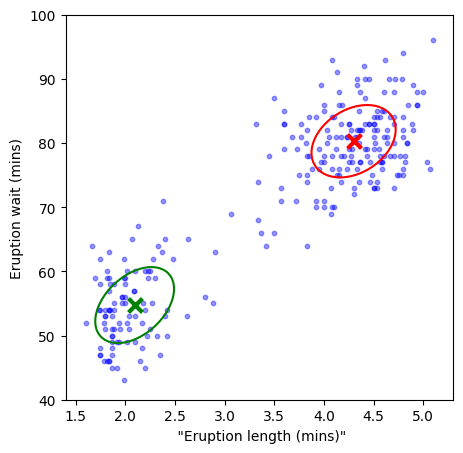

In [69]:
Y, _, _, _ = K_means(X, K)
priors = get_prior_probabilities(Y, K)
means = get_centroids(X, Y, K)
Sigmas = get_within_class_covariances(X, Y, K, means)

fig, ax = plt.subplots(figsize=(5,5))

ax.set_xlim(left=1.4, right=5.3)
ax.set_ylim(bottom=40, top=100)

ax.set_xlabel(data.columns[0])
ax.set_ylabel(data.columns[1])

plot_all(ax, X, K=K, Y=None, means=means, Sigmas=Sigmas, Y_colors=None, N=100)

**Example:** training using the EM-algorithm, with initial parameters based on K-means clustering. Note that the number of iterations is usually quite small.

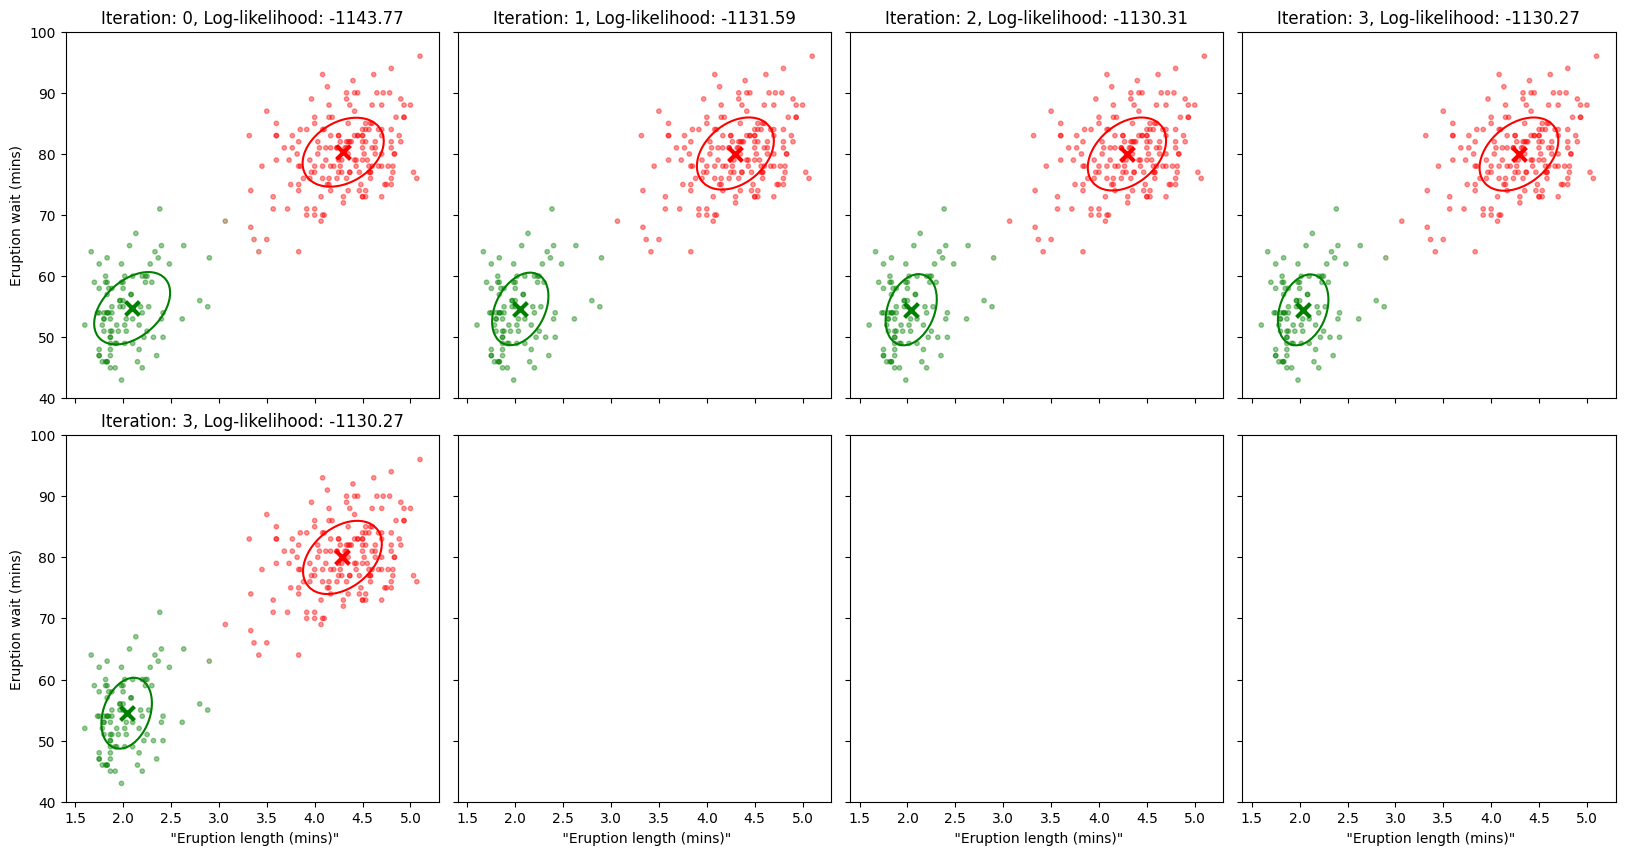

In [70]:
snapshots_i = [0, 1, 2, 3, 5, 8, 12, -1]
means, Sigmas, priors, i, _, snapshots = EM_algorithm(X,
                                                      means,
                                                      Sigmas,
                                                      priors,
                                                      tolerance=0.0001,
                                                      iter_max=100,
                                                      snapshots_i=snapshots_i)

nrows = 2
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(20,10))
fig.subplots_adjust(wspace=0.05, hspace=0.1)

counter = 0
for i in range(nrows):
    for j in range(ncols):
        ax = axes[i,j]
        
        if counter < len(snapshots):
            iteration, means, Sigmas, priors, LL = snapshots[counter]
            
            pZgivenX = E_step(X, means, Sigmas, priors)
            Y_colors = list(map(lambda x: colorFader("red", "green", mix=x), pZgivenX[:, 1]))
        
            plot_all(ax, X, K=K, Y=None, means=means, Sigmas=Sigmas, Y_colors=Y_colors, N=100)
            
            ax.set_title("Iteration: {}, Log-likelihood: {:.2f}".format(iteration, LL))
        
        if i==1 and j==0:
            ax.set_xlim(left=1.4, right=5.3)
            ax.set_ylim(bottom=40, top=100)
        if j==0:
            ax.set_ylabel(data.columns[1])
        if i==1:
            ax.set_xlabel(data.columns[0])
            
        counter += 1